# Plot the model outputs

In [1]:
import pandas as pd
from simpler_mpl import set_common_mpl_styles
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import matplotlib.pyplot as plt
from simpler_pandas import apply_labelling, sanity_check, show_df_details
from labelling import format_to_base_10

%load_ext autoreload
%autoreload 2

In [2]:
MARKETING_COST_PER_INSURED = 20
VALUE_PER_RETAINED_CONTRACT = 1000
ONE_MILLION = 1_000_000

#economic = f"${VALUE_PER_RETAINED_CONTRACT:0.0f} earned per retained contract and ${MARKETING_COST_PER_INSURED:0.0f} cost per marketing action"
#economic

In [3]:
uplift_result_file = "df_comparison_uplift.pickle"
df_comparison_uplift = pd.read_pickle(uplift_result_file)
churn_result_file = "df_comparison_churn.pickle"
df_comparison_churn = pd.read_pickle(churn_result_file)
dummy_result_file = "df_comparison_dummy.pickle"
df_comparison_dummy = pd.read_pickle(dummy_result_file)

df_to_plot = pd.concat((df_comparison_dummy, df_comparison_churn, df_comparison_uplift), axis=1)

def check_series_is_ordered(ser, ascending=True):
    """Check 1 series is ascending"""
    assert ascending==True, "Haven't done descending yet, nor tested this"
    return (ser.shift()[1:].reset_index(drop=True) >= ser[:-1].reset_index(drop=True)).all()

assert check_series_is_ordered(df_to_plot['churn_proba_pos'])
assert check_series_is_ordered(df_to_plot['dummy_proba_pos'])
assert check_series_is_ordered(df_to_plot['uplift_diff_t_c'])

df_to_plot

,dummy_proba_pos,dummy_will_churn,churn_proba_pos,churn_will_churn,uplift_diff_t_c,uplift_will_churn
0,0.15827,0,0.999292,1,-0.064676,0
1,0.15827,0,0.999292,1,-0.064676,0
2,0.15827,0,0.999292,1,-0.064676,1
3,0.15827,0,0.999292,1,-0.064676,0
4,0.15827,0,0.999292,1,-0.064676,0
...,...,...,...,...,...,...
49995,0.15827,0,0.062501,0,0.046170,0
49996,0.15827,0,0.062501,0,0.046170,1
49997,0.15827,0,0.062501,0,0.046170,0
49998,0.15827,1,0.062501,0,0.046170,0


In [4]:
sanity_check(df_to_plot)
show_df_details(df_to_plot)

is view False, is consolidated False, single block False, numeric mixed True
6 blocks looking like:
(NumericBlock: slice(0, 1, 1), 1 x 50000, dtype: float64, NumericBlock: slice(1, 2, 1), 1 x 50000, dtype: int64, NumericBlock: slice(2, 3, 1), 1 x 50000, dtype: float64, NumericBlock: slice(3, 4, 1), 1 x 50000, dtype: int64, NumericBlock: slice(4, 5, 1), 1 x 50000, dtype: float64, NumericBlock: slice(5, 6, 1), 1 x 50000, dtype: int64)


In [5]:
def calculate_value_generated(dfx, col_will_churn, model_name):
    # assume we're sorted
    #df_costing = dfx.sort_values(col, ascending=ascending).copy().reset_index(drop=True)
    df_costing = dfx[[col_will_churn]].copy()
    #df_costing['price_if_mktd'] = -1
    #df_costing['price_if_mktd_cumsum'] = df_costing['price_if_mktd'].cumsum()
    #df_costing['price_if_retained'] = 1000 * (df_costing[col_will_churn]==0)
    value_column = f"{model_name}_value"
    df_costing[value_column] = (VALUE_PER_RETAINED_CONTRACT * (df_costing[col_will_churn]==0)) - MARKETING_COST_PER_INSURED
    value_column_cumsum = f"{model_name}_value_cumsum"
    df_costing[value_column_cumsum] = df_costing[value_column].cumsum()
    return df_costing[[value_column, value_column_cumsum]]

df_costing_uplift = calculate_value_generated(df_to_plot, "uplift_will_churn", "uplift")
#df_costing.iloc[10000]
df_costing_uplift

,uplift_value,uplift_value_cumsum
0,980,980
1,980,1960
2,-20,1940
3,980,2920
4,980,3900
...,...,...
49995,980,41191080
49996,-20,41191060
49997,980,41192040
49998,980,41193020


In [6]:
df_costing_churn = calculate_value_generated(df_to_plot, "churn_will_churn", "churn")

In [7]:
df_costing_dummy = calculate_value_generated(df_to_plot, "dummy_will_churn", "dummy")

In [8]:
df_to_plot = pd.concat((df_costing_dummy, df_costing_churn, df_costing_uplift), axis=1)
df_to_plot.sample(5).sort_index()

,dummy_value,dummy_value_cumsum,churn_value,churn_value_cumsum,uplift_value,uplift_value_cumsum
561,980,459760,980,449760,980,502760
9056,-20,7497860,980,7106860,980,7941860
9759,980,8068800,980,7689800,980,8556800
22146,980,18242060,-20,18019060,980,18856060
41130,980,33813380,980,34132380,980,34629380


In [9]:
#row_with_minimum_uplift_effect = (0 - df_comparison_uplift['uplift_diff_t_c'].abs()).idxmax()
#row_with_minimum_uplift_effect
#print(f"By insured {row_with_minimum_uplift_effect:,} the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign")
#print(f"By this point we've incurred a marketing cost of ${MARKETING_COST_PER_INSURED * row_with_minimum_uplift_effect:,}.")
#df_to_plot.loc[row_with_minimum_uplift_effect]

In [10]:
row_choice = 10_000
print(f"By this point ({row_choice:,}) we've incurred a marketing cost of ${MARKETING_COST_PER_INSURED * row_choice:,}.")

df_to_plot.iloc[row_choice]

By this point (10,000) we've incurred a marketing cost of $200,000.


dummy_value                980
dummy_value_cumsum     8272980
churn_value                980
churn_value_cumsum     7898980
uplift_value               980
uplift_value_cumsum    8752980
Name: 10000, dtype: int64

In [11]:
row_choice = row_with_minimum_uplift_effect = (0 - df_comparison_uplift['uplift_diff_t_c'].abs()).idxmax()
print(f"By insured {row_choice:,} the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign")
print(f"By this point we've incurred a marketing cost of ${MARKETING_COST_PER_INSURED * row_choice:,}.")

df_to_plot.iloc[row_choice]

By insured 41,796 the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign
By this point we've incurred a marketing cost of $835,920.


dummy_value                 980
dummy_value_cumsum     34361060
churn_value                 980
churn_value_cumsum     34650060
uplift_value                -20
uplift_value_cumsum    35076060
Name: 41796, dtype: int64

In [12]:
df_to_plot['dummy_value_cumsum'] = df_to_plot['dummy_value_cumsum'] / ONE_MILLION
df_to_plot['churn_value_cumsum'] = df_to_plot['churn_value_cumsum'] / ONE_MILLION
df_to_plot['uplift_value_cumsum'] = df_to_plot['uplift_value_cumsum'] / ONE_MILLION

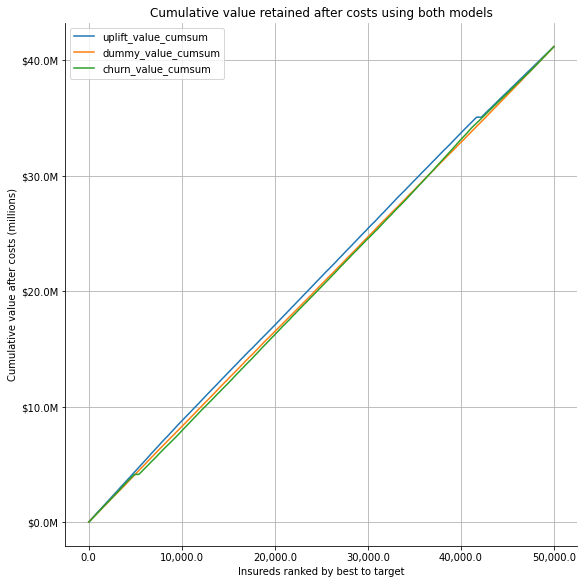

In [13]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
df_to_plot[:50_000].plot(y=['uplift_value_cumsum', 'dummy_value_cumsum', 'churn_value_cumsum'], ax=ax);
title = "Cumulative value retained after costs using both models"
set_common_mpl_styles(ax, grid_axis="both", xlabel="Insureds ranked by best to target", 
                      ylabel="Cumulative value after costs (millions)", title=title)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:}M'))

In [14]:
quantile = pd.cut(df_to_plot.index, 5, right=False)
quantile

[[0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), ..., [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999)]
Length: 50000
Categories (5, interval[float64, left]): [[0.0, 9999.8) < [9999.8, 19999.6) < [19999.6, 29999.4) < [29999.4, 39999.2) < [39999.2, 50048.999)]

In [15]:
mean_result_by_quantile = df_to_plot.groupby(quantile)[['uplift_value', 'dummy_value', 'churn_value']].mean()
mean_result_by_quantile.index = apply_labelling(mean_result_by_quantile.index, format_to_base_10)
mean_result_by_quantile

,uplift_value,dummy_value,churn_value
[0.00 - 10.00k),875.2,827.2,789.8
[10.00k - 20.00k),830.4,824.0,833.4
[20.00k - 30.00k),837.4,818.3,831.7
[30.00k - 40.00k),827.9,820.2,859.2
[40.00k - 50.05k),748.5,829.7,805.3


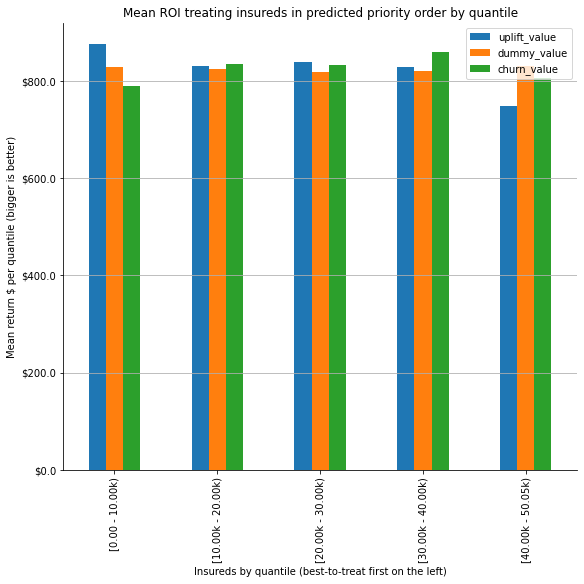

In [16]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
mean_result_by_quantile.plot(kind='bar', ax=ax)
title = "Mean ROI treating insureds in predicted priority order by quantile"
set_common_mpl_styles(ax, grid_axis="y", xlabel="Insureds by quantile (best-to-treat first on the left)", title=title, ylabel="Mean return $ per quantile (bigger is better)")
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

<AxesSubplot:>

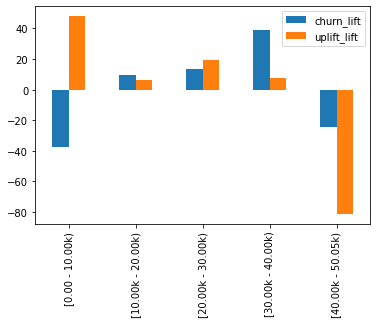

In [17]:
churn_from_dummy = mean_result_by_quantile['churn_value'] - mean_result_by_quantile['dummy_value']
uplift_from_dummy = mean_result_by_quantile['uplift_value'] - mean_result_by_quantile['dummy_value']
lift_from_dummy = pd.concat((churn_from_dummy, uplift_from_dummy), axis=1)
lift_from_dummy.columns = ['churn_lift', 'uplift_lift']
lift_from_dummy.plot(kind='bar')

In [18]:
sum_result_by_quantile = df_to_plot.groupby(quantile)[['uplift_value', 'dummy_value', 'churn_value']].sum()
sum_result_by_quantile.index = apply_labelling(sum_result_by_quantile.index, format_to_base_10)
sum_result_by_quantile

,uplift_value,dummy_value,churn_value
[0.00 - 10.00k),8752000,8272000,7898000
[10.00k - 20.00k),8304000,8240000,8334000
[20.00k - 30.00k),8374000,8183000,8317000
[30.00k - 40.00k),8279000,8202000,8592000
[40.00k - 50.05k),7485000,8297000,8053000


<AxesSubplot:>

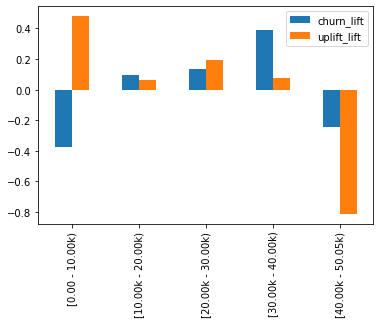

In [19]:
churn_from_dummy = sum_result_by_quantile['churn_value'] - sum_result_by_quantile['dummy_value']
uplift_from_dummy = sum_result_by_quantile['uplift_value'] - sum_result_by_quantile['dummy_value']
lift_from_dummy = pd.concat((churn_from_dummy, uplift_from_dummy), axis=1)
lift_from_dummy /= ONE_MILLION
lift_from_dummy.columns = ['churn_lift', 'uplift_lift']
lift_from_dummy.plot(kind='bar')

In [20]:
lift_from_dummy

,churn_lift,uplift_lift
[0.00 - 10.00k),-0.374,0.480
[10.00k - 20.00k),0.094,0.064
[20.00k - 30.00k),0.134,0.191
[30.00k - 40.00k),0.390,0.077
[40.00k - 50.05k),-0.244,-0.812


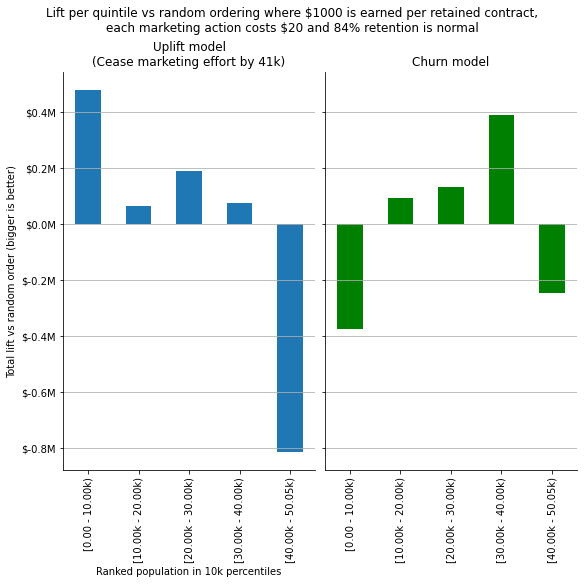

In [21]:
fig, axs = plt.subplot_mosaic([['Uplift', 'Churn']], sharex=True, sharey=True, figsize=(8, 8), constrained_layout=True)
lift_from_dummy['uplift_lift'].plot(kind='bar', ax=axs['Uplift'])
lift_from_dummy['churn_lift'].plot(kind='bar', ax=axs['Churn'], color='g')
title = f'Uplift model\n(Cease marketing effort by {int(row_with_minimum_uplift_effect/1000)}k)'
set_common_mpl_styles(ax=axs['Uplift'], ylabel='Total lift vs random order (bigger is better)', 
                      title=title, xlabel='Ranked population in 10k percentiles')
set_common_mpl_styles(ax=axs['Churn'], title='Churn model')
title = f"Lift per quintile vs random ordering where \${VALUE_PER_RETAINED_CONTRACT:0.0f} is earned per retained contract,\neach marketing action costs ${MARKETING_COST_PER_INSURED:0.0f} and 84% retention is normal"
fig.suptitle(title);
axs['Uplift'].get_legend().remove()
axs['Churn'].get_legend().remove()
axs['Uplift'].yaxis.set_major_formatter(StrMethodFormatter('${x:2.1f}M'))